#  DeblurGAN-v2

In this Notebook, I have implemented DeblurGAN-v2 model and got the outputs as required after deblurring of image.

DeblurGAN-v2 is a generative adversarial network (GAN) for single image motion deblurring. This model is based
on a relativistic conditional GAN with a double-scale discriminator.

# 1.Preparation of Model

**Importing the Required Packages** 


In [1]:
import collections
import os
import sys
import time
import matplotlib

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from openvino.runtime import Core


sys.path.append("../utils")
import notebook_utils as utils

**Downloading the Model**

In [2]:
# this is the directory where model will be downloaded
model_directory = "model"

# name of the model as named in Open Model Zoo
model_name = "deblurgan-v2"

download_command = f"omz_downloader " \
                   f"--name {model_name} " \
                   f"--output_dir {model_directory} " \
                   f"--cache_dir {model_directory}"
! $download_command

################|| Downloading deblurgan-v2 ||################

========== Retrieving model\public\deblurgan-v2\models\__init__.py from the cache

========== Retrieving model\public\deblurgan-v2\models\fpn_mobilenet.py from the cache

========== Retrieving model\public\deblurgan-v2\models\mobilenet_v2.py from the cache

========== Retrieving model\public\deblurgan-v2\models\networks.py from the cache

========== Retrieving model\public\deblurgan-v2\ckpt\fpn_mobilenet.h5 from the cache

========== Replacing text in model\public\deblurgan-v2\models\networks.py
========== Replacing text in model\public\deblurgan-v2\models\fpn_mobilenet.py
========== Replacing text in model\public\deblurgan-v2\models\fpn_mobilenet.py



**Converting the Model**

In [3]:
precision = "FP16"

# setting the output path for the conversion
converted_model_path = f"model/public/{model_name}/{precision}/{model_name}.xml"

if not os.path.exists(converted_model_path):
    converting_command = f"omz_converter " \
                      f"--name {model_name} " \
                      f"--download_dir {base_model_dir} " \
                      f"--precisions {precision}"
    ! $converting_command

# 2.Loading the Deblurgan-v2 Model

As we have Downloaded and converted the Model, now we need to load the Model.

This deblurgan-v2 Model takes the input image of shape (1,3,736,1312) in the shape format of(Batch Size, Channels, Height, Width) and output the image of same shape after deblurring it.

Here we have loaded the model using ie_core.read_model and compiled it using ie_core.compile_model and gets information about the input shape.


In [4]:
ie_core = Core()

model = ie_core.read_model(model=converted_model_path)
compiled_model = ie_core.compile_model(model=model, device_name="CPU")

# get input and output nodes
input_layer = next(iter(compiled_model.inputs))
output_layer = next(iter(compiled_model.outputs))

# get input size
channels, height, width = list(input_layer.shape)[1:4]

# 3. Loading and Preproceesing of Image

Now we will make some functions to preprocess the image and prepare it for input. 
We will load the image, reshape it and pad it. 

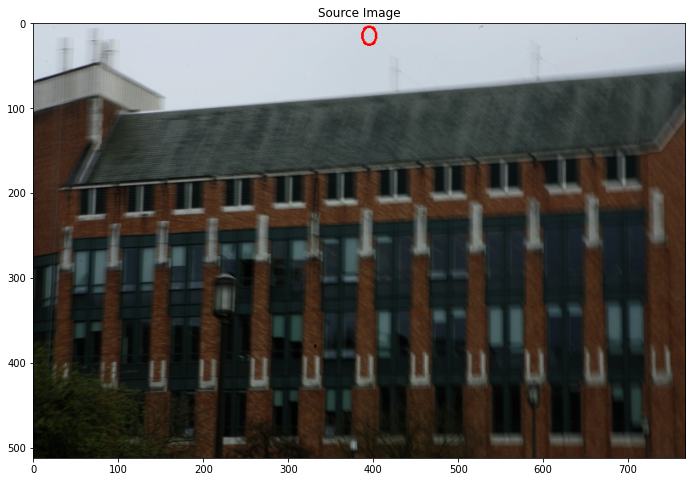

In [5]:
def convert_bgr_to_rgb(src_img):
    """
    This function converts BGR image to RGB image
    It takes a BGR image input as numpy array and returns the RGB image
    """
    return cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)


def resizing(img):

    """
    This funtion takes an image as input, reshape it(keeping the aspect ratio same)
    to minimum width or minimum height(depending upon which will make the other dimension
    smaller than input dimension) and then pad it to make it equal to the required input 
    dimenision and return the image of dimension(height ,width, channels)

    While padding the image, this function also stores the coordinates where the actual part
    of image is located in the padded image as to convert the output image back to the shape 
    of source image.

    """
    h, w, _ = img.shape
    crop_dims = []

    maximum_width = (w * height) // h
    if maximum_width <= width:
        img = cv2.resize(img, (maximum_width, height))

        left_padding = (width - maximum_width) // 2
        right_padding = width - maximum_width - left_padding

        crop_dims.append(0)
        crop_dims.append(height)
        crop_dims.append(left_padding + 1)
        crop_dims.append(left_padding + maximum_width + 1)

        img = np.pad(
            img,
            [(0, 0), (left_padding, right_padding), (0, 0)],
            "constant",
            constant_values=0,
        )

    else:
        maximum_height = (h * width) // w
        img = cv2.resize(img, (width, maximum_height))

        top_padding = (height - maximum_height) // 2
        bottom_padding = height - maximum_height - top_padding

        crop_dims.append(top_padding + 1)
        crop_dims.append(top_padding + maximum_height + 1)
        crop_dims.append(0)
        crop_dims.append(width)

        img = np.pad(
            img,
            [(top_padding, bottom_padding), (0, 0), (0, 0)],
            "constant",
            constant_values=0,
        )

    return img, crop_dims


def finalising_input_image(img):

    """
    This function takes an image as input and first change its shape from (height, width, channels) 
    to (channels, height, width) and then expands its dimension to make the dimension equal 
    to input dimension i.e. (1, channels, height, width)

    """

    img = np.moveaxis(img, 2, 0)
    h, w, _ = img.shape
    img = np.expand_dims(img, axis=0)
    return img


def plot_image(img1, img2, title1, title2):
    """
    This Function shows the image with the title given as input
    """
    plt.figure(figsize=(16, 8))

    if title2 == None:
        plt.subplot(1, 1, 1)
        plt.imshow(img1)
        plt.title(title1)

    else:
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title(title1)

        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title(title2)


# Taking input the source image
src_img = cv2.imread("data/input/blurred.png")

# Converting it to RGB format
src_img = convert_bgr_to_rgb(src_img)

# Resizing the image
resized_image, crop_dims = resizing(src_img)

# Finalising the input image
input_image = finalising_input_image(resized_image)

# Showing the Source Image
plot_image(src_img, None, "Source Image", None)


# 4. Inference and Getting the Result

Now we will input the input_image in the compiled model and get the result_image from it.

In [6]:
# Giving the processed input image in the model and getting the results
result_image = compiled_model([input_image])[output_layer]
print(f"Model's output shape: {result_image.shape}")

Model's output shape: (1, 3, 736, 1312)


# 5. Post-processing of Output Image and Plotting the Result

Now we will define a function to get the image of same shape as source image from the Model's Output.
In this function, we will remove padding and reshape it to the shape of source image.

Final Output image shape: (512, 768, 3)


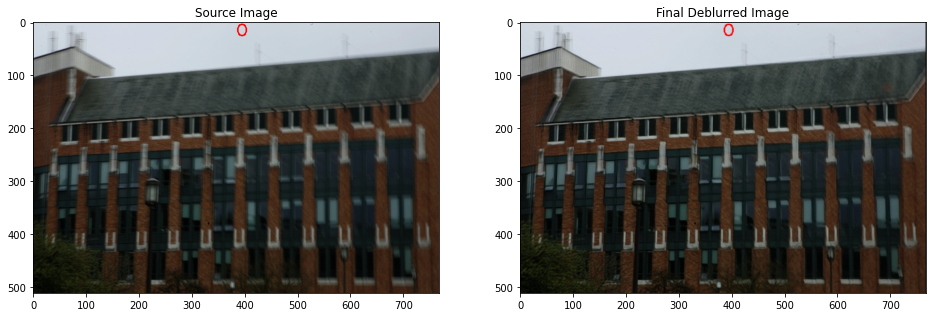

In [7]:
def result_to_image(res, src_img, crop_dims):

    """
    This function takes the result image as input along with the source image and croping dimensions
    and first crops the image with the input cropping dimensions(to remove the padding) and
    then reshape the result image to the dimension of source image.
    """

    res = (res - res.min()) / (res.max() - res.min())  # to normalize
    res = (res * 255).astype(np.uint8)

    # Converting the result image into desired dimensions
    res = res.reshape((channels, height, width))
    res = np.moveaxis(res, 0, -1)
    h, w, _ = src_img.shape
    res = res[crop_dims[0] : crop_dims[1], crop_dims[2] : crop_dims[3]]
    res = cv2.resize(res, (w, h))

    return res


# Changing the shape of result image to source image
result_image = result_to_image(result_image, src_img, crop_dims)
print(f"Final Output image shape: {result_image.shape}")

plot_image(src_img, result_image, "Source Image", "Final Deblurred Image")

# 5. Saving the Result in a File

In [8]:
# Making the Output Directory
os.makedirs("Output", exist_ok=True)

# Saving the image
cv2.imwrite(f"data/output/deblurred_image.png",cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))

True